In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import make_column_selector as selector

In [2]:
file_path = r'E:\8sem\Capstone 2\dataset\loan_approval_dataset.csv'
ldf = pd.read_csv(file_path)

In [3]:
ldf.shape

(4269, 13)

In [4]:
ldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [5]:
ldf = ldf.drop(columns=['loan_id'])

In [6]:
ldf.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [7]:
ldf.isnull().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

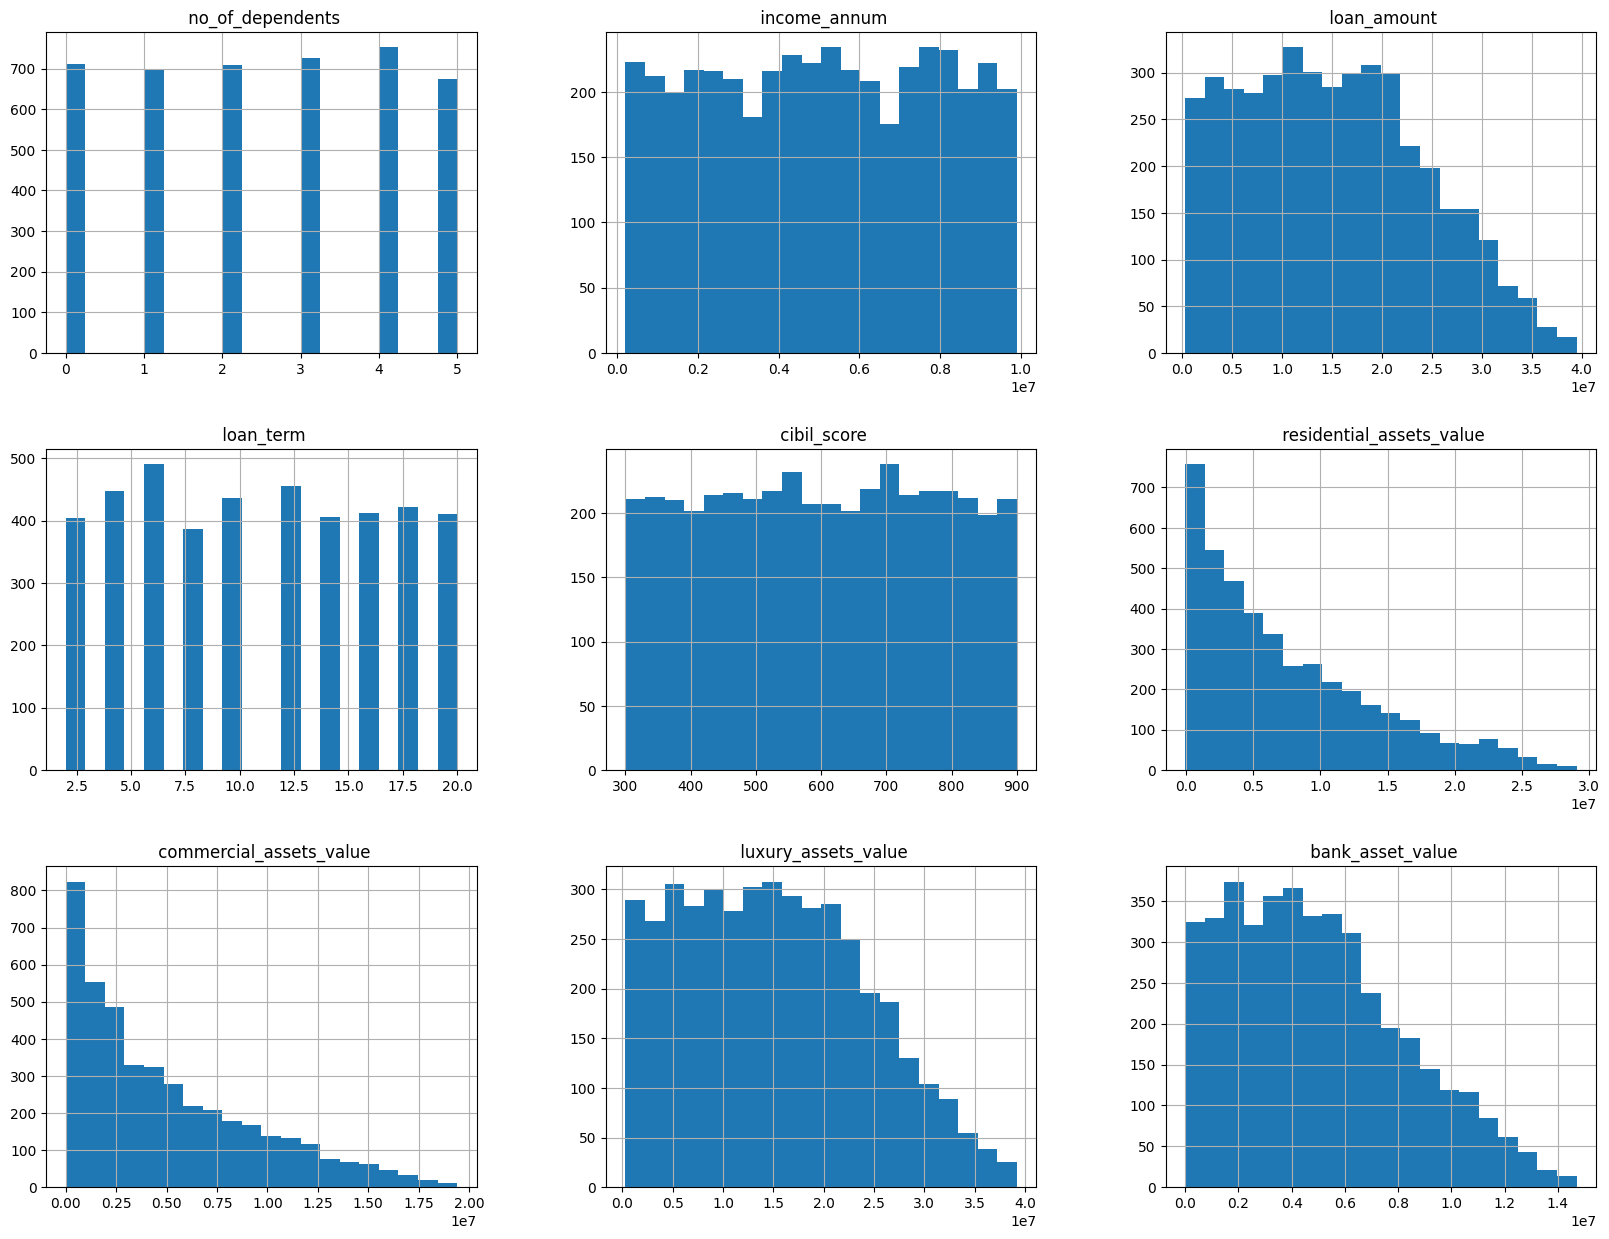

In [8]:
#Distribution
ldf.hist(bins=20, figsize=(20, 15))
plt.show()

In [9]:
from plotnine import ggplot, aes, geom_point, labs, theme_minimal, theme


# Create the ggplot object and specify aesthetics (aes)
plot = (ggplot(ldf, aes(x=' income_annum', y=' loan_amount', color=' loan_status')) +
        geom_point() +  # Adjust size and stroke as needed
        labs(title='Income vs Loan Amount', x='Income Annual', y='Loan Amount') +
        theme_minimal() +
        theme(figure_size=(10, 6))  # Adjust figure size as needed
       )

# Print the plot
print(plot)

<ggplot: (1000 x 600)>


C:\Users\Dell\AppData\Local\Temp\ipykernel_16580\2769487061.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



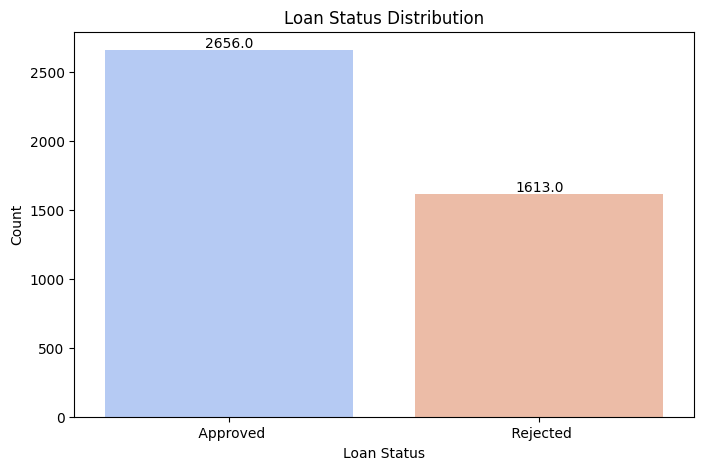

In [10]:
#Converting loan status into categorical
ldf[' loan_status'] = ldf[' loan_status'].astype('category')

#Barplot 
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=' loan_status', data=ldf, palette='coolwarm')
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

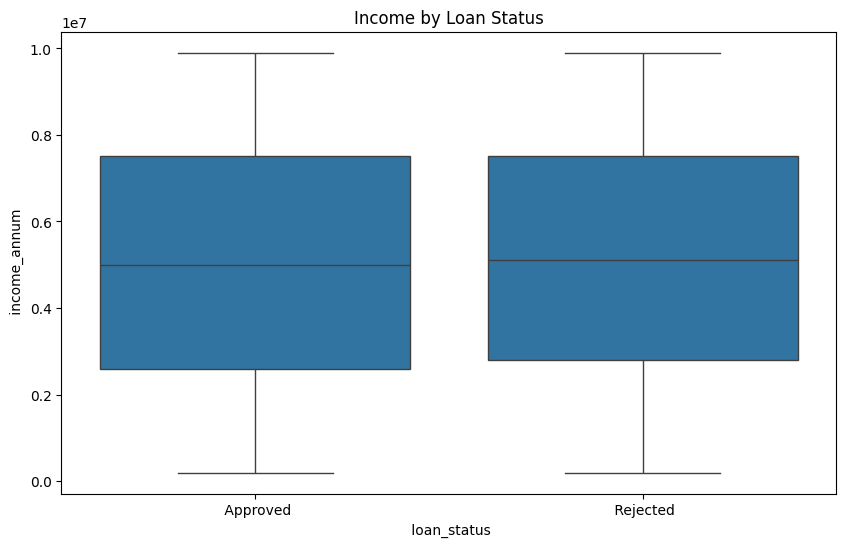

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=' loan_status', y=' income_annum', data=ldf)
plt.title('Income by Loan Status')
plt.show()

In [12]:
# Clean data
ldf = ldf.applymap(lambda x: x.strip() if isinstance(x, str) else x)

C:\Users\Dell\AppData\Local\Temp\ipykernel_16580\542012844.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [13]:
# Convert loan status to binary
ldf[' loan_status'] = ldf[' loan_status'].apply(lambda x: 1 if x == 'Approved' else 0)

In [14]:
# Split data into features and target
X = ldf.drop(' loan_status', axis=1)
y = ldf[' loan_status']

In [15]:
# Define preprocessing for numeric and categorical features
numeric_features = selector(dtype_include=np.number)
categorical_features = selector(dtype_include=object)

In [16]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [18]:
# Split the data into training and test sets using stratification
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [19]:
# Define the under-sampler
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)

In [20]:
# Apply under-sampling
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

In [21]:
# Check class distribution after under-sampling
print("Under-sampled training set class distribution:")
print(pd.Series(y_train_under).value_counts())

Under-sampled training set class distribution:
 loan_status
1    1290
0    1290
Name: count, dtype: int64


In [22]:
models_with_weights = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

In [23]:
# Train and evaluate models with class weights
print("\nModels with class weights:")
results_with_weights = {}
for model_name, model in models_with_weights.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train, y_train)  # Use original data here
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results_with_weights[model_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


Models with class weights:


In [24]:
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("\n")

Model: Gradient Boosting
Accuracy: 0.9824
Precision: 0.9831
Recall: 0.9887
F1 Score: 0.9859
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       323
           1       0.98      0.99      0.99       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

[[314   9]
 [  6 525]]




In [25]:
# Define base models
model1 = LogisticRegression(max_iter=1000, class_weight='balanced')
model2 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model3 = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [26]:
# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', model1),
    ('rf', model2),
    ('gb', model3)
], voting='soft')

In [27]:
# Train and evaluate voting classifier
clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', voting_clf)])
clf.fit(X_train, y_train)  # Use original data here
y_pred = clf.predict(X_test)

In [28]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [29]:
print(f"Voting Classifier")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Voting Classifier
Accuracy: 0.9778
Precision: 0.9885
Recall: 0.9755
F1 Score: 0.9820
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       323
           1       0.99      0.98      0.98       531

    accuracy                           0.98       854
   macro avg       0.97      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

[[317   6]
 [ 13 518]]


In [30]:
# Print summary of results
print("Summary of model performance with class weights:")
for model_name, metrics in results_with_weights.items():
    print(f"{model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")

Summary of model performance with class weights:
Logistic Regression:
  accuracy: 0.9239
  precision: 0.9551
  recall: 0.9209
  f1: 0.9377
Random Forest:
  accuracy: 0.9824
  precision: 0.9850
  recall: 0.9868
  f1: 0.9859
Gradient Boosting:
  accuracy: 0.9824
  precision: 0.9831
  recall: 0.9887
  f1: 0.9859


In [31]:
print("\nVoting Classifier:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Voting Classifier:
Accuracy: 0.9778
Precision: 0.9885
Recall: 0.9755
F1 Score: 0.9820


In [32]:
from joblib import dump

In [33]:
dump(clf, './../predictionModel/model.joblib')

['./../predictionModel/model.joblib']

In [34]:
dump(preprocessor, './../predictionModel/preprocessor.joblib')

['./../predictionModel/preprocessor.joblib']

In [35]:
dump(clf, './../predictionModel/model.pkl')

['./../predictionModel/model.pkl']